## PACKAGES

In [1]:
# packages
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime as dt

## DATA

In [2]:
df1 = pd.read_csv('../goodtrainbadtrain/data/select_2020.csv',encoding='iso-8859-2',sep=';')
df2 = pd.read_csv('../goodtrainbadtrain/data/select_2021.csv',encoding='iso-8859-2',sep=';')
df3 = pd.read_csv('../goodtrainbadtrain/data/select_2022.csv',encoding='iso-8859-2',sep=';')

df = pd.concat([df1, df2, df3])


## FILTER

In [3]:
#filter for München and Köln
df = df.query("bhf in ('München Hbf', 'Köln Hbf', 'Köln Messe/Deutz Gl.11-12', 'Frankfurt(M) Flughafen Fernbf', 'Mannheim Hbf', 'Stuttgart Hbf', 'Würzburg Hbf', 'Frankfurt(Main) Hbf', 'Nürnberg Hbf')")  

## PROCESS AND CLEAN

In [4]:
#1) cleaning of train names 
#some letters of 'zugnr' are not capitalized
df['zugnr'] = df['zugnr'].str.upper()

#2)process of 9999 in arrTime and depTime: add new column with info 
df['start_or_endpoint'] = 'nan'
df.loc[df['arrTime'] == 9999, 'start_or_endpoint'] = 'start'
df.loc[df['depTime'] == 9999, 'start_or_endpoint'] = 'end'
#overwrite 9999 with respective arr/dep time of same observation (in new clean columns)
df['arrTime_clean'] = np.where(df['arrTime'] == 9999, df['depTime'], df['arrTime'])
df['depTime_clean'] = np.where(df['depTime'] == 9999, df['arrTime'], df['depTime'])

#3)some times need to be filled up with 0's. eg. '5' -> 00:05
df['arrTime_clean'] = df['arrTime_clean'].astype(str)
df['arrTime_clean'] = df['arrTime_clean'].map(lambda a: a.zfill(4))
df['depTime_clean'] = df['depTime_clean'].astype(str)
df['depTime_clean'] = df['depTime_clean'].map(lambda a: a.zfill(4))

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 370942 entries, 15 to 289495
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   zugnr              370942 non-null  object
 1   datum              370942 non-null  object
 2   bhf                370942 non-null  object
 3   arrTime            370942 non-null  int64 
 4   adelay             370942 non-null  int64 
 5   depTime            370942 non-null  int64 
 6   ddelay             370942 non-null  int64 
 7   start_or_endpoint  370942 non-null  object
 8   arrTime_clean      370942 non-null  object
 9   depTime_clean      370942 non-null  object
dtypes: int64(4), object(6)
memory usage: 31.1+ MB


# FEATURE ENGENEERING

In [6]:
#1)add city feature (merged Köln Hbf/ Messe Deutz)
df['city'] = df.bhf
df['city'] = df['city'].str.replace('Köln Messe/Deutz Gl.11-12','Köln')
df['city'] = df['city'].str.replace('Köln Hbf','Köln')
df['city'] = df['city'].str.replace('München Hbf','München')

df['city'] = df['city'].apply(lambda x: x.replace('Frankfurt(M) Flughafen Fernbf','Frankfurt'))
df['city'] = df['city'].apply(lambda x: x.replace('Frankfurt(Main) Hbf','Frankfurt'))

df['city'] = df['city'].str.replace('Nürnberg Hbf','Nürnberg')
df['city'] = df['city'].str.replace('Stuttgart Hbf','Stuttgart')
df['city'] = df['city'].str.replace('Würzburg Hbf','Würzburg')
df['city'] = df['city'].str.replace('Mannheim Hbf','Mannheim')

#2) add date column
df['date'] = df['datum'] + ' ' + df['arrTime_clean']
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H%M')
#3) add month of the year 
df['weekday'] = df['date'].dt.day_name()
#4) add month of the year 
df['month'] = df['date'].dt.month_name()

#time of the day
df['time_of_day'] = pd.cut(pd.to_datetime(df.date).dt.hour,
       bins=[0, 6, 12, 18, 24],
       labels=['night', 'morning', 'afternoon', 'evening'],
       right=False,
       include_lowest=True)

#todo
#3) add public holiday
#4) add covid lockdown?

/tmp/ipykernel_601/3035154968.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['city'] = df['city'].str.replace('Köln Messe/Deutz Gl.11-12','Köln')


### ADD DIRECTON INFO

In [7]:
journeys = pd.read_csv('../goodtrainbadtrain/data/journeyindex.csv')

#processing
journeys = journeys[journeys.leg1_train.notna()] #delete duplicated trips that once go to köln hbf and once to deutz
journeys = journeys[journeys.leg2_train.notna()] 
journeys = journeys[journeys.leg3_train.notna()] 

journeys = journeys.drop(['Unnamed: 0'],axis=1) 
journeys['key_ID'] = list(range(journeys.shape[0]))

#rename columns (necessary for wide_to_long function)
journeys.columns = [ 'date', 'weekday', 'month', 'journey_origin',
       'journey_destination', 'journey_start', 'journey_end',
       'journey_duration', 'journey_numberlegs', 
       'train_leg1', 'origin_leg1','destination_leg1', 'start_leg1', 'end_leg1', 'duration_leg1',
       'train_leg2', 'origin_leg2', 'destination_leg2', 'start_leg2','end_leg2', 'duration_leg2', 
       'train_leg3', 'origin_leg3','destination_leg3', 'start_leg3', 'end_leg3', 'duration_leg3', 
       'key_ID']

journeys_long = pd.wide_to_long(df = journeys,
                                stubnames=['train', 'origin','destination', 'start', 'end', 'duration'],
                                i=['key_ID'],
                                j='leg',
                                sep = '_',
                                suffix='.+').reset_index()

#delete empty legs
journeys_long = journeys_long[journeys_long.train != '-1']

#reorder columns
journeys_long = journeys_long[['key_ID', 
 'journey_origin', 'journey_destination','journey_start','journey_end','journey_duration', 'journey_numberlegs',
 'leg', 'train', 'origin', 'destination', 'start', 'end','duration',
 'date', 'month','weekday']]


def date_transformation(df, columns):
    for col in columns:
        df[col] = df[col].str.split('+', expand=True)[[0]]
        df[col] = pd.to_datetime(df[col])
    return df


journeys_long = date_transformation(journeys_long, ['journey_start', 'journey_end']) #, 'start', 'end'])
journeys_long['month'] = journeys_long['journey_start'].dt.month_name()
journeys_long['weekday'] = journeys_long['journey_start'].dt.day_name()

journeys_long['origin_city'] = journeys_long.origin
journeys_long['destination_city'] = journeys_long.destination

journeys_long['origin_city'] = journeys_long['origin_city'].apply(lambda x: x.replace('Frankfurt(Main) Flughafen Fernbf','Frankfurt'))
journeys_long['origin_city'] = journeys_long['origin_city'].apply(lambda x: x.replace('Frankfurt(Main) Hbf','Frankfurt'))
journeys_long['origin_city'] = journeys_long['origin_city'].str.replace('Köln Hbf', 'Köln')
journeys_long['origin_city'] = journeys_long['origin_city'].str.replace('München Hbf', 'München')
journeys_long['origin_city'] = journeys_long['origin_city'].str.replace('Köln Messe/Deutz Gl.11-12','Köln')
journeys_long['origin_city'] = journeys_long['origin_city'].str.replace('Nürnberg Hbf','Nürnberg')
journeys_long['origin_city'] = journeys_long['origin_city'].str.replace('Stuttgart Hbf','Stuttgart')
journeys_long['origin_city'] = journeys_long['origin_city'].str.replace('Würzburg Hbf','Würzburg')
journeys_long['origin_city'] = journeys_long['origin_city'].str.replace('Mannheim Hbf','Mannheim')


journeys_long['destination_city'] = journeys_long['destination_city'].apply(lambda x: x.replace('Frankfurt(Main) Flughafen Fernbf','Frankfurt'))
journeys_long['destination_city'] = journeys_long['destination_city'].apply(lambda x: x.replace('Frankfurt(Main) Hbf','Frankfurt'))
journeys_long['destination_city'] = journeys_long['destination_city'].str.replace('Köln Hbf', 'Köln')
journeys_long['destination_city'] = journeys_long['destination_city'].str.replace('München Hbf', 'München')
journeys_long['destination_city'] = journeys_long['destination_city'].str.replace('Köln Messe/Deutz Gl.11-12','Köln')
journeys_long['destination_city'] = journeys_long['destination_city'].str.replace('Nürnberg Hbf','Nürnberg')
journeys_long['destination_city'] = journeys_long['destination_city'].str.replace('Stuttgart Hbf','Stuttgart')
journeys_long['destination_city'] = journeys_long['destination_city'].str.replace('Würzburg Hbf','Würzburg')
journeys_long['destination_city'] = journeys_long['destination_city'].str.replace('Mannheim Hbf','Mannheim')

journeys_long['trip'] = journeys_long['origin_city'] + '-' + journeys_long['destination_city']

ice_df = journeys_long[['origin_city','destination_city','trip','train']].groupby(['origin_city','destination_city','trip'])['train'].apply(','.join).reset_index()

df_list = []

for index, row in ice_df.iterrows():
    data = df[df.city == row.destination_city]
    data = data[data['zugnr'].isin(row.train.split(','))]
    data['trip'] = row.trip
    df_list.append(data) 

df = pd.concat(df_list, ignore_index = True)

/tmp/ipykernel_601/2636704437.py:55: FutureWarning: The default value of regex will change from True to False in a future version.
  journeys_long['origin_city'] = journeys_long['origin_city'].str.replace('Köln Messe/Deutz Gl.11-12','Köln')
/tmp/ipykernel_601/2636704437.py:66: FutureWarning: The default value of regex will change from True to False in a future version.
  journeys_long['destination_city'] = journeys_long['destination_city'].str.replace('Köln Messe/Deutz Gl.11-12','Köln')


In [8]:
ice_df

,origin_city,destination_city,trip,train
0,Frankfurt,Köln,Frankfurt-Köln,"ICE 316,ICE 316,ICE 316,ICE 316,ICE 316,ICE 31..."
1,Frankfurt,Mannheim,Frankfurt-Mannheim,"ICE 101,ICE 103,ICE 107,ICE 109,ICE 201,ICE 20..."
2,Frankfurt,München,Frankfurt-München,"railje63,ICE 695,ICE 771,railje63,ICE 729,rail..."
3,Frankfurt,Stuttgart,Frankfurt-Stuttgart,"ICE 571,ICE 573,ICE 577,ICE 579,ICE 571,ICE 57..."
4,Köln,Frankfurt,Köln-Frankfurt,"ICE 521,ICE 11,ICE 13,ICE 315,ICE 17,ICE 159,I..."
5,Köln,Mannheim,Köln-Mannheim,"ICE 101,ICE 103,ICE 255,ICE 107,ICE 109,ICE 20..."
6,Köln,München,Köln-München,"ICE 521,ICE 511,ICE 513,ICE 515,ICE 517,ICE 51..."
7,Mannheim,Frankfurt,Mannheim-Frankfurt,"ICE 202,ICE 200,ICE 108,ICE 106,ICE 254,ICE 10..."
8,Mannheim,Köln,Mannheim-Köln,"ICE 202,ICE 200,ICE 108,ICE 106,ICE 254,ICE 10..."
9,Mannheim,München,Mannheim-München,"ICE 591,ICE 593,ICE 595,ICE 597,ICE 599,ICE 69..."


In [9]:
df[df.trip=='München-Köln']

,zugnr,datum,bhf,arrTime,adelay,depTime,ddelay,start_or_endpoint,arrTime_clean,depTime_clean,city,date,weekday,month,time_of_day,trip
77176,ICE 512,2019-12-15,Köln Hbf,2205,0,9999,0,end,2205,2205,Köln,2019-12-15 22:05:00,Sunday,December,evening,München-Köln
77177,ICE 512,2019-12-16,Köln Hbf,2205,34,9999,34,end,2205,2205,Köln,2019-12-16 22:05:00,Monday,December,evening,München-Köln
77178,ICE 512,2019-12-17,Köln Hbf,2205,21,9999,21,end,2205,2205,Köln,2019-12-17 22:05:00,Tuesday,December,evening,München-Köln
77179,ICE 512,2019-12-18,Köln Hbf,2205,2,9999,0,end,2205,2205,Köln,2019-12-18 22:05:00,Wednesday,December,evening,München-Köln
77180,ICE 512,2019-12-19,Köln Hbf,2205,10,9999,0,end,2205,2205,Köln,2019-12-19 22:05:00,Thursday,December,evening,München-Köln
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97105,NJ 420,2022-05-11,Köln Hbf,651,11,658,7,nan,0651,0658,Köln,2022-05-11 06:51:00,Wednesday,May,morning,München-Köln
97106,NJ 420,2022-05-12,Köln Hbf,651,62,658,58,nan,0651,0658,Köln,2022-05-12 06:51:00,Thursday,May,morning,München-Köln
97107,NJ 420,2022-05-13,Köln Hbf,651,118,658,114,nan,0651,0658,Köln,2022-05-13 06:51:00,Friday,May,morning,München-Köln
97108,NJ 420,2022-05-14,Köln Hbf,651,88,658,84,nan,0651,0658,Köln,2022-05-14 06:51:00,Saturday,May,morning,München-Köln


# ADD WEATHER

In [10]:
#5) add weather variables
df['sharp_date'] = df['date'].dt.round('H')
df['sharp_date']  = df.sharp_date.astype('str')

cgn_data = pd.read_csv('../goodtrainbadtrain/data/koln.csv')
muc_data = pd.read_csv('../goodtrainbadtrain/data/munchen.csv')

fra_data = pd.read_csv('../goodtrainbadtrain/data/frankfurt.csv')
man_data = pd.read_csv('../goodtrainbadtrain/data/mannheim.csv')
nur_data = pd.read_csv('../goodtrainbadtrain/data/nurnberg.csv')
stu_data = pd.read_csv('../goodtrainbadtrain/data/stuttgart.csv')
wur_data = pd.read_csv('../goodtrainbadtrain/data/wurzburg.csv')


weather = {"Köln": cgn_data, 
           "München": muc_data, 
           "Frankfurt": fra_data, 
           "Mannheim": man_data, 
           "Nürnberg": nur_data, 
           "Stuttgart": stu_data,
           "Würzburg": wur_data}


total_df =  pd.DataFrame()
for station, w_df in weather.items():
    weather_data = weather[station]
    weather_data['sharp_date']  = weather_data.time.astype('str')
    station_df = pd.merge(df[df['city'] == station], weather_data, how='left', left_on='sharp_date', right_on='sharp_date')
    total_df = pd.concat([total_df, station_df])


df = total_df.drop(columns=['dwpt', 'rhum', 'wdir', 'pres', 'tsun'])
df['snow'] = df['snow'].replace(np.nan, 0)

# Load coco file
coco = pd.read_csv('../goodtrainbadtrain/data/weather_coco.csv', sep=';')
coco.set_index('Code', inplace=True)
coco = coco.to_dict()['Weather Condition']

# Define new classification for coco
new_classes = {
    'good': [1, 2],
    'medium': [3, 4, 7, 14],
    'bad': [5, 8, 10, 12, 15, 17, 19, 21, 23, 24, 25],
    'extreme': [6, 9, 11, 13, 16, 18, 20, 22, 26, 27]
}

# Apply new classification for coco
reclass = {}
for k, values in new_classes.items():
    for v in values:
        for c in range(1, 28):
            if v == c:
                reclass[v] = k

reclass = dict(sorted(reclass.items()))
df['coco'] = df['coco'].map(reclass)

In [11]:
df

,zugnr,datum,bhf,arrTime,adelay,depTime,ddelay,start_or_endpoint,arrTime_clean,depTime_clean,...,time_of_day,trip,sharp_date,time,temp,prcp,snow,wspd,wpgt,coco
0,ICE 100,2019-12-15,Köln Hbf,2305,0,2310,0,nan,2305,2310,...,evening,Frankfurt-Köln,2019-12-15 23:00:00,2019-12-15 23:00:00,5.3,0.0,0.0,10.4,13.0,medium
1,ICE 100,2019-12-16,Köln Hbf,2305,0,2310,0,nan,2305,2310,...,evening,Frankfurt-Köln,2019-12-16 23:00:00,2019-12-16 23:00:00,9.5,0.0,0.0,18.4,27.0,medium
2,ICE 100,2019-12-17,Köln Hbf,2305,14,2311,14,nan,2305,2311,...,evening,Frankfurt-Köln,2019-12-17 23:00:00,2019-12-17 23:00:00,11.0,0.2,0.0,10.1,18.0,medium
3,ICE 100,2019-12-18,Köln Hbf,2305,2,2311,2,nan,2305,2311,...,evening,Frankfurt-Köln,2019-12-18 23:00:00,2019-12-18 23:00:00,8.6,0.0,0.0,20.2,35.0,good
4,ICE 100,2019-12-19,Köln Hbf,2305,0,2310,0,nan,2305,2310,...,evening,Frankfurt-Köln,2019-12-19 23:00:00,2019-12-19 23:00:00,10.1,0.0,0.0,25.9,37.0,good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3086,IC 2266,2022-05-11,Stuttgart Hbf,1504,4,1509,5,nan,1504,1509,...,afternoon,München-Stuttgart,2022-05-11 15:00:00,2022-05-11 15:00:00,28.1,0.0,0.0,13.7,37.0,good
3087,IC 2266,2022-05-12,Stuttgart Hbf,1504,8,1509,9,nan,1504,1509,...,afternoon,München-Stuttgart,2022-05-12 15:00:00,2022-05-12 15:00:00,22.4,0.0,0.0,16.9,32.0,medium
3088,IC 2266,2022-05-13,Stuttgart Hbf,1504,34,1509,34,nan,1504,1509,...,afternoon,München-Stuttgart,2022-05-13 15:00:00,2022-05-13 15:00:00,20.7,0.0,0.0,14.8,29.0,good
3089,IC 2266,2022-05-14,Stuttgart Hbf,1504,4,1509,9,nan,1504,1509,...,afternoon,München-Stuttgart,2022-05-14 15:00:00,2022-05-14 15:00:00,22.4,0.0,0.0,10.1,22.0,medium


# TARGET PROCESSING

In [12]:
#1) into several categories
# adelay-> into categories: no delay, small delay, medium delay, (big delay/cancellation)
max = df.adelay.max()
bins = [-2, -0.1, 0, 5, 30, max]
group_names = ['large delay/cancelled','on time','small delay', 'medium delay', 'large delay/cancelled']
df['target'] = pd.cut(df['adelay'], bins, labels=group_names, ordered=False)

#value counts of target:
#on time                  67336
#small delay              28649
#medium delay             23617
#large delay/cancelled    10677

#2) binary target (on time - or not)
df['target_binary'] =  (df['adelay'] == 0)*1

#3) numeric target (cancelled and extreme values = 120 Min)
df['target_numeric'] = df['adelay']
df['target_numeric'] = np.where(df['target_numeric'] == -1, 120, df['target_numeric'])
df['target_numeric'] = np.where(df['target_numeric'] > 120, 120, df['target_numeric'])
#sns.boxplot(df['target_numeric'])

# CORRELATION / TARGET VISUALIZATION

<AxesSubplot:xlabel='weekday', ylabel='target_numeric'>

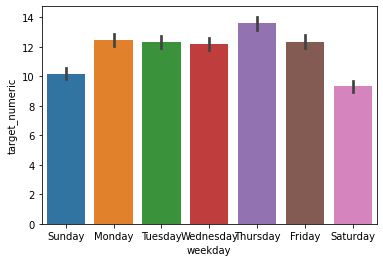

In [13]:
sns.barplot(x= df.weekday, y=df.target_numeric)

<AxesSubplot:xlabel='month', ylabel='target_numeric'>

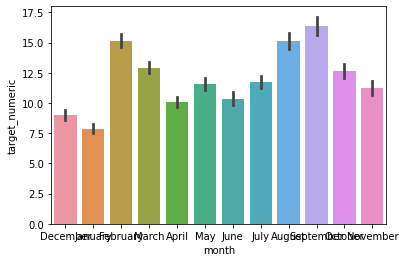

In [14]:
sns.barplot(x= df.month, y=df.target_numeric)

# SAVE DATA

In [105]:
df = df[['zugnr', 'trip', 'city',  'bhf', 
    'date', 'datum', 'sharp_date', 'weekday', 'month', 'time_of_day',
    'arrTime_clean','adelay',  'target', 'target_binary','target_numeric',
    'temp', 'prcp', 'snow', 'wspd', 'wpgt', 'coco']]

In [106]:
df.to_csv('../goodtrainbadtrain/data/data_for_model_legs.csv')